In [ ]:
#
# Code to generate sharp-LIME explanations on Camelyon images (without nuclei contours)
#

In [ ]:
!pip uninstall lime -y
!pip install git+https://github.com/palatos/lime@ColorExperiments

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input

from lime import lime_image

from skimage.segmentation import mark_boundaries

In [46]:
camelyon_segmentations['all500/tumor/level7/centre1/patient020/node4/patches'].keys()

<KeysViewHDF5 ['122', '133', '184', '245', '278', '290', '352', '355', '382', '396', '410', '412', '451', '493', '65', '69', '85']>

In [26]:
model = tf.keras.models.load_model('/mnt/nas2/results/IntermediateResults/Mara/MELBA/baseline_def_1/best_model.h5', compile=False)
model.layers[-1].activation = tf.keras.activations.sigmoid
model.compile()

In [27]:
#We don't directly use the base model because we want to be sure we are perturbing the images before preprocessing them.
#Otherwise covering the superpixels in 0 might not mean covering them in black.
#Best way to control this is to just define a wrapper-like class around the model, that includes the preprocessing in it.
#I'm also converting the sigmoid output to softmax-like because that's generally easier to handle and debug in LIME.
#GradCAM doesn't care about any of this so we can just use the model directly.

class MyModel():
    def __init__(self,model):
        self.model = model
        self.input_shape = model.input_shape
        self.output_shape = model.output_shape
        
    def predict(self, batch_images):
        
        #Image must be preprocessed before passed to LIME.
        batch_images = preprocess_input(batch_images.copy()) 
        
        sigm = self.model.predict(batch_images)
        
        softm = np.hstack((1-sigm,sigm))
        
        return softm


model_with_preprocessing = MyModel(model)

In [55]:
filename = "/mnt/nas2/results/IntermediateResults/Camelyon/all500/patches.hdf5"
camelyon_segmentations=h5py.File('/mnt/nas2/results/IntermediateResults/Camelyon/cam_nuclei.h5py', 'r')
f = h5py.File(filename,'r')

im = camelyon_segmentations['all500/tumor/level7/centre1/patient020/node4/patches/352/patch'][:]
mask = camelyon_segmentations['all500/tumor/level7/centre1/patient020/node4/patches/352/mask'][:,:,0]

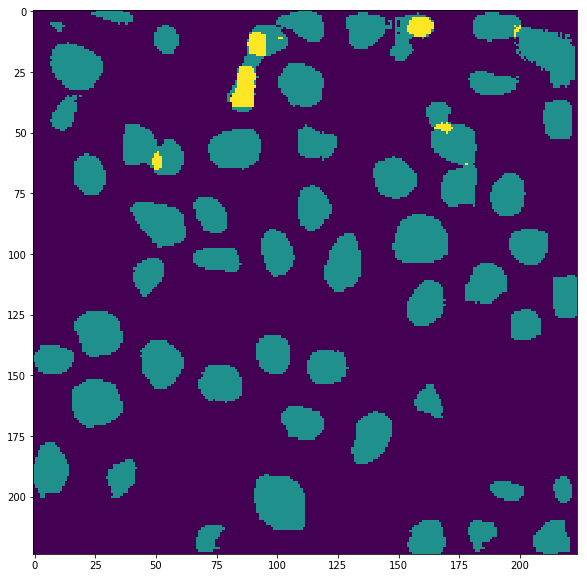

In [56]:
plt.imshow(mask)
def connected_components(image):
    # list of tags we have used 
    tags = []
    # current  tag (remember 1 and 0 are already in image so start from 2)
    tag = 2
    # counter
    cntr = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] != 0:
                if i != 0 and j != 0 and image[i, j-1] != 0 and image[i-1, j] != 0 and image[i-1, j] != image[i, j-1]:
                    image[i, j] = image[i, j - 1]
                    tags.remove(image[i - 1, j])
                    cntr -= 1
                    image[image == image[i - 1, j]] = image[i, j]
                elif i != 0 and image[i-1, j] != 0:
                    image[i, j] = image[i-1, j]
                elif j != 0 and image[i, j-1] != 0:
                    image[i, j] = image[i, j-1]
                else:
                    image[i, j] = tag
                    tags.append(tag)
                    tag += 1
                    cntr += 1
    
    return cntr, tags

In [57]:
cntr, tags=connected_components(mask)

In [59]:
#Generate Squares
squares = np.zeros(im.shape[:2])
counter = 0
for hor in range(3):
    for ver in range(3):
        squares[75*hor:75*(hor+1),75*ver:75*(ver+1)]=counter
        counter+=1

#Renumber segments, because they are numbered arbitrarily in the mask files.
#segments = np.sum(mask[:,:,0:5],axis=2).copy()
segments = mask[:,:].copy()
temp_renumber = [8+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

#LIME is expecting a segmentation function, so we define one just to pass the segments above as superpixels.
def segfunc(im):
    return segments

#Mark the nuclei
mark_colors = [[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]
mark = im.copy()/255

for i in range(5):
    mark = mark_boundaries(mark,mask[:,:].astype('uint8'),mode='outer',outline_color=mark_colors[i])

In [61]:
#Generate LIME explanation for class 1
explainer = lime_image.LimeImageExplainer()
class_idx=1
explanation_genetic = explainer.explain_instance(im.copy(), 
                                                 model_with_preprocessing.predict, 
                                                 segmentation_fn = None,# segfunc, 
                                                 top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                 hide_color=0,#Cover superpixels in black. 
                                                 num_samples=200,
                                                 progress_bar=False)
dict_genetic = dict(explanation_genetic.local_exp[class_idx])
heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
#Generate LIME explanation for class 1
explainer = lime_image.LimeImageExplainer()
class_idx=1
explanation_genetic = explainer.explain_instance(im.copy(), 
                                                 model_with_preprocessing.predict, 
                                                 segmentation_fn = segfunc, 
                                                 top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                 hide_color=0,#Cover superpixels in black. 
                                                 num_samples=200,
                                                 progress_bar=False)
dict_genetic = dict(explanation_genetic.local_exp[class_idx])
sharp_heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)

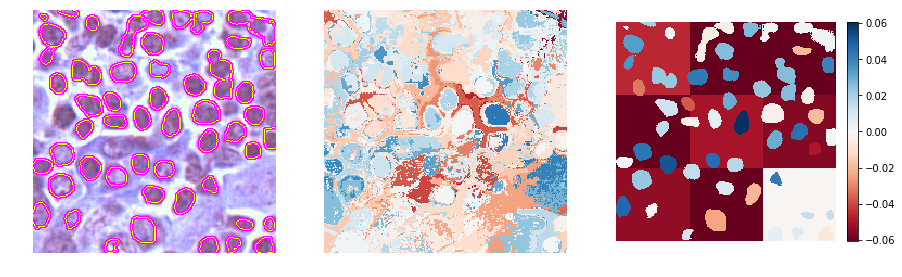

In [62]:
plt.rcParams['figure.figsize']=(20,10)
plt.subplot(1,4,1)
plt.imshow(mark)
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(heatmap, cmap = 'RdBu', vmin=-sharp_heatmap.max(), vmax = sharp_heatmap.max())
plt.axis('off')
plt.subplot(1,4,3)
im=plt.imshow(sharp_heatmap, cmap = 'RdBu', vmin=-sharp_heatmap.max(), vmax = sharp_heatmap.max())
plt.axis('off')
plt.colorbar(im,fraction=0.045)#,cax=cax)
